In [31]:
import numpy as np
import torch
torch.set_default_tensor_type(torch.DoubleTensor)

import matplotlib.pyplot as plt

rng = np.random.default_rng()

T = 250 # how long to simulate the trajectory
state_dim = 2 # Dimension of the state-space
input_dim = 1 # Dimension of inputs
obs_dim = state_dim # for now
NUM_TRAJ_TRAIN = 100 # number of trajectories to simulate for training data
NUM_TRAJ_TEST = 20
num_trajs = NUM_TRAJ_TRAIN + NUM_TRAJ_TEST

In [32]:
theta = 1/360*2*np.pi # one degree

A = np.array([[np.cos(theta), -np.sin(theta)], # state transition matrix
              [np.sin(theta),  np.cos(theta)]]) # moving around a circle at 1 deg per timestep
B = np.array([[0.5], [0.7]]) # input transformation
C = np.eye(obs_dim, state_dim) # Using identity map for now
Q = 0.001*np.eye(state_dim) # Covariance matrix of process noise
R = 0.01*np.eye(obs_dim) # Covariance matrix of sensor noise
x0 = np.array([1.0, 0.0], dtype=np.float64) # starting state
u_seq = 0.05 * (rng.random(size=(num_trajs, T, input_dim))*2 - 1)
traj = np.zeros(shape=(num_trajs, T, state_dim))
meas = np.zeros(shape=(num_trajs, T, obs_dim))

for traj_index in range(num_trajs):
    x = x0
    for i in range(T):
        u_t = u_seq[traj_index, i]
        w_t = rng.multivariate_normal(mean=np.zeros(state_dim), cov=Q) # process noise
        x = A @ x + w_t + B @ u_t # inputs
        v_t = rng.multivariate_normal(mean=np.zeros(obs_dim), cov=R) # sensor noise
        y = C @ x + v_t
        traj[traj_index, i] = x
        meas[traj_index, i] = y

<Figure size 432x288 with 0 Axes>

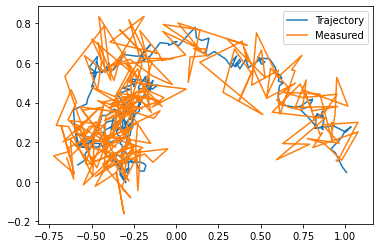

In [33]:
index_to_visualize = 109

# plot trajectory and noisy measurements
plt.figure()
fig, ax = plt.subplots()
linetraj, = ax.plot(traj[index_to_visualize, :,0], traj[index_to_visualize, :,1], label='Trajectory')
linemeas, = ax.plot(meas[index_to_visualize, :,0], meas[index_to_visualize, :,1], label='Measured')

plt.legend()
plt.show()

# Now, let's see if a transformer can learn the dynamics and filter the position

In [34]:
from transformer import *
from transformer_attention import AttentionQKV
from transformer_attention import MultiHeadProjection
from transformer import PositionEmbedding

embed_dim = 36 # use 36-dimensional embedding for now
batch_size = 10

### Train-Test Split

In [35]:
# Training Data
indices_train = np.arange(NUM_TRAJ_TRAIN)
np.random.shuffle(indices_train)

# The input to the model will be a concatenation of the current measured state and the "u" input at this timestep
target_sequences_train = torch.from_numpy(meas)[indices_train,:,:]
input_sequences_train = torch.from_numpy(u_seq)[indices_train,:,:]
transformer_input_train = torch.cat((target_sequences_train, input_sequences_train), dim=2)
true_positions_train = torch.from_numpy(traj)[indices_train,:,:]


# Test Data
indices_test = np.arange(NUM_TRAJ_TRAIN, NUM_TRAJ_TRAIN+NUM_TRAJ_TEST)
np.random.shuffle(indices_test)

traj_test = traj[indices_test,:,:]
meas_test = meas[indices_test,:,:]
target_sequences_test = torch.from_numpy(meas)[indices_test,:,:]
input_sequences_test = torch.from_numpy(u_seq)[indices_test,:,:]
transformer_input_test = torch.cat((target_sequences_test, input_sequences_test), dim=2)
true_positions_test = torch.from_numpy(traj)[indices_test,:,:]


## GPT-style: Transformer Decoder only for Autoregressive generation

Compare to:
* Just the last timestep (ZOH) 
* Run A, B system on last timesteps (no noise) 

In [36]:
num_epochs = 200

gpt_model = TransformerDecoder(seq_input_size=(obs_dim+input_dim), embed_size=embed_dim, output_size=state_dim,
                 n_layers=3, n_heads=6, d_filter=256, dropout=None)
optimizer = torch.optim.Adam(gpt_model.parameters())

losses = []
loss_func = torch.nn.MSELoss(reduction='sum')

for i in range(num_epochs):
    for batchNum in range(NUM_TRAJ_TRAIN // batch_size):
        
        transformer_input_batch = transformer_input_train[batchNum*batch_size:(batchNum+1)*batch_size, :, :]
        target_sequence_batch = target_sequences_train[batchNum*batch_size:(batchNum+1)*batch_size, :, :]  #TRYING TO HIT NOISY DATA
        #target_sequence_batch = true_positions_train[batchNum*batch_size:(batchNum+1)*batch_size, :, :]
        
#         print(transformer_input_batch.shape)
#         print(target_sequence_batch.shape)
        decoder_output = gpt_model(transformer_input_batch, decoder_mask=None, mask_future=True, shift_target_sequence_right=True)

        loss = loss_func(decoder_output, target_sequence_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        curr_loss = loss.item()
        losses.append(curr_loss)
        
    print('Epoch', i, ": Loss", curr_loss)

Epoch 0 : Loss 436.68551304102147
Epoch 1 : Loss 224.97911007601184
Epoch 2 : Loss 161.00422569970448
Epoch 3 : Loss 136.58949358476883
Epoch 4 : Loss 125.1706937414373
Epoch 5 : Loss 112.71558745662294
Epoch 6 : Loss 107.70541912921219
Epoch 7 : Loss 105.691032038865
Epoch 8 : Loss 103.02497471927025
Epoch 9 : Loss 101.11159170889803
Epoch 10 : Loss 99.85664034484145
Epoch 11 : Loss 98.62914359009824
Epoch 12 : Loss 97.70273178110028
Epoch 13 : Loss 97.01690268826965
Epoch 14 : Loss 96.35299645923418
Epoch 15 : Loss 95.78185985984678
Epoch 16 : Loss 95.32548504669819
Epoch 17 : Loss 94.95795192967454
Epoch 18 : Loss 94.67911663260881
Epoch 19 : Loss 94.44430943753693
Epoch 20 : Loss 94.2185078418178
Epoch 21 : Loss 93.99766835463717
Epoch 22 : Loss 93.82826258579799
Epoch 23 : Loss 93.74819205481714
Epoch 24 : Loss 93.72690516318767
Epoch 25 : Loss 93.67187247426094
Epoch 26 : Loss 93.53587121414856
Epoch 27 : Loss 93.3331689198615
Epoch 28 : Loss 93.07466862549822
Epoch 29 : Loss 92.

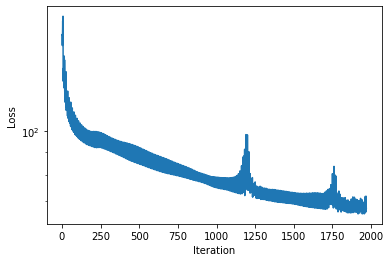

In [37]:
plt.figure()
plt.plot(losses[30:])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.yscale("log")
plt.show()

<Figure size 432x288 with 0 Axes>

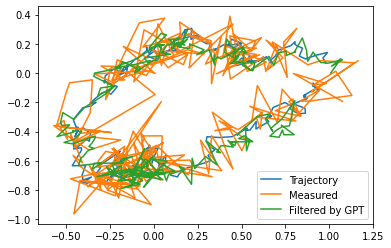

Error between traj and meas 4.957596636242935
Error between filtered and traj 2.943640360579382
Error between filtered and meas 7.931797767824324


In [38]:
gpt_transformer_sim = gpt_model(transformer_input_test, decoder_mask=None, mask_future=True, shift_target_sequence_right=True)

# Index that we want to visualize from the test indices
ind_to_vis = 9 # 0 through 20

filtered = gpt_transformer_sim.detach().numpy()

plt.figure()
fig, ax = plt.subplots()
linetraj, = ax.plot(traj_test[ind_to_vis, :,0], traj_test[ind_to_vis, :,1], label='Trajectory')
linemeas, = ax.plot(meas_test[ind_to_vis, :,0], meas_test[ind_to_vis, :,1], label='Measured')
linegpt, = ax.plot(filtered[ind_to_vis, :, 0], filtered[ind_to_vis, :, 1], label='Filtered by GPT')
plt.legend()
plt.show()

print('Error between traj and meas', np.linalg.norm(traj_test - meas_test)**2 / NUM_TRAJ_TEST)
print('Error between filtered and traj', np.linalg.norm(filtered - traj_test)**2 / NUM_TRAJ_TEST)
print('Error between filtered and meas', np.linalg.norm(filtered - meas_test)**2 / NUM_TRAJ_TEST)

## BERT-style: Transformer Encoder only, fill in the blanks for the trajectory 

Compare to: 
* Average between different timesteps for the missing ones (PWL linear interpolation)
* Just the last step (ZOH interpolation)

In [18]:
num_epochs = 100
p = 0.15 # probability of zeroing out a token

bert_model = TransformerEncoder(seq_input_size=(obs_dim+input_dim), # size of the input tokens (obs_dim + input_dim)
                embed_size=embed_dim, output_size=state_dim, 
                n_layers=3, n_heads=6, d_filter=256, 
                dropout=None)
optimizer = torch.optim.Adam(bert_model.parameters())

loss_func = torch.nn.MSELoss(reduction='sum')
losses = []

for i in range(num_epochs):
    for batchNum in range(NUM_TRAJ_TRAIN // batch_size):
        
        #Randomly zero-out p% of the tokens in transformer_input_train - different for each batch each time
        mask = torch.bernoulli( (1-p) * torch.ones(size=(batch_size, T) ) )
        mask = mask.repeat(obs_dim+input_dim, 1, 1).permute(1, 2, 0)
        # print("mask is", mask)
        
        transformer_input_batch = transformer_input_train[batchNum*batch_size:(batchNum+1)*batch_size, :, :] * mask
        # transformer_input_batch has shape [batch_size, seq_len, (obs_dim+input_dim)] 
        
        #target_sequence_batch = target_sequences_train[batchNum*batch_size:(batchNum+1)*batch_size, :, :]
        
        true_positions_batch = true_positions_train[batchNum*batch_size:(batchNum+1)*batch_size, :, :]
         # What percent of them are zeroed out?
#         zeroed = 0
#         for batch in transformer_input_batch: 
#             for seq_elt in batch: 
#                 if all(seq_elt == 0.0): zeroed += 1
#         print("percent zeroed", zeroed / (batch_size * T) )
        
        encoder_output = bert_model(transformer_input_batch, encoder_mask=None)

        loss = loss_func(encoder_output, true_positions_batch) #,target_sequences_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        curr_loss = loss.item()
        losses.append(curr_loss)
        
    print('Epoch', i, ": Loss", curr_loss)

Epoch 0 : Loss 1206.8832698757083
Epoch 1 : Loss 504.16056280828604
Epoch 2 : Loss 460.8819962748186
Epoch 3 : Loss 369.2912353358794
Epoch 4 : Loss 316.1474143980463
Epoch 5 : Loss 300.9470335276138
Epoch 6 : Loss 257.47160122998787
Epoch 7 : Loss 249.57779413711933
Epoch 8 : Loss 200.11734267386439
Epoch 9 : Loss 190.0999464377012
Epoch 10 : Loss 163.91957923517904
Epoch 11 : Loss 138.58575061014554
Epoch 12 : Loss 135.06961253324215
Epoch 13 : Loss 130.3879586870603
Epoch 14 : Loss 116.84060095618975
Epoch 15 : Loss 110.33439953343321
Epoch 16 : Loss 106.57326168895182
Epoch 17 : Loss 98.86483372601298
Epoch 18 : Loss 90.83483254076599
Epoch 19 : Loss 87.65233151163707
Epoch 20 : Loss 78.97590213496693
Epoch 21 : Loss 82.04292057764383
Epoch 22 : Loss 76.56902885416494
Epoch 23 : Loss 74.98786425782052
Epoch 24 : Loss 74.79745714029777
Epoch 25 : Loss 73.63814893445894
Epoch 26 : Loss 70.53494669433682
Epoch 27 : Loss 66.90882880884368
Epoch 28 : Loss 67.25244587298829
Epoch 29 : Lo

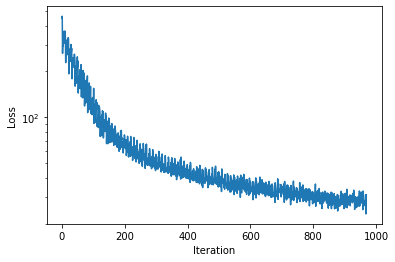

In [21]:
plt.figure()
plt.plot(losses[30:])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.yscale("log")
plt.show()

<Figure size 432x288 with 0 Axes>

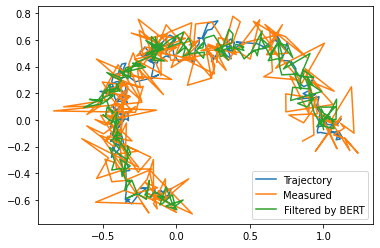

Error between traj and meas 5.073473410984201
Error between filtered and traj 3.443973091737335
Error between filtered and meas 4.023352553109396


In [25]:
p_test = 0.0

#Randomly zero-out p% of the tokens in target_sequences_train
mask_test = torch.bernoulli( (1-p_test) * torch.ones(size=(NUM_TRAJ_TEST, T) ) )
mask_test = mask_test.repeat(obs_dim+input_dim, 1, 1).permute(1, 2, 0)
# print("mask is", mask)

transformer_input_test_masked = transformer_input_test * mask_test
bert_transformer_sim = bert_model(transformer_input_test_masked, encoder_mask=None)

# Index that we want to visualize from the test indices
ind_to_vis = 2

filtered = bert_transformer_sim.detach().numpy()

plt.figure()
fig, ax = plt.subplots()
linetraj, = ax.plot(traj_test[ind_to_vis, :,0], traj_test[ind_to_vis, :,1], label='Trajectory')
linemeas, = ax.plot(meas_test[ind_to_vis, :,0], meas_test[ind_to_vis, :,1], label='Measured')
linegpt, = ax.plot(filtered[ind_to_vis, :, 0], filtered[ind_to_vis, :, 1], label='Filtered by BERT')
plt.legend()
plt.show()

print('Error between traj and meas', np.linalg.norm(traj_test - meas_test)**2 / NUM_TRAJ_TEST)
print('Error between filtered and traj', np.linalg.norm(filtered - traj_test)**2 / NUM_TRAJ_TEST)
print('Error between filtered and meas', np.linalg.norm(filtered - meas_test)**2 / NUM_TRAJ_TEST)